# Classification of Subreddits

In [94]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, plot_roc_curve
from sklearn.pipeline import make_pipeline

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [2]:
# read in cleaned data
reddits = pd.read_csv('data/clean_reddits.csv')

In [3]:
reddits.head(2)

,author,created_utc,permalink,subreddit,text
0,dwaxe,1601660299,/r/TheOnion/comments/j3z3ds/real_estate_expert...,TheOnion,Real Estate Experts Confirm Having George Cloo...
1,kc9283,1601604158,/r/TheOnion/comments/j3m23g/subway_bread_isnt_...,TheOnion,"Subway bread isn't bread, Irish court says"


In [4]:
reddits.tail(2)

,author,created_utc,permalink,subreddit,text
29976,tamilidhal,1601267115,/r/news/comments/j15hsk/படடததரவகளல_பஙகறற_வலவயப...,news,போட்டித்தேர்வுகளில் பங்கேற்று வேலைவாய்ப்பு பெற...
29977,tamilidhal,1601267114,/r/news/comments/j15hs8/கரககல_அரச_மரததவமனயல_சம...,news,காரைக்கால் அரசு மருத்துவமனையில் சிமென்ட் காரை ...


In [5]:
reddits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29978 entries, 0 to 29977
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   author       29978 non-null  object
 1   created_utc  29978 non-null  int64 
 2   permalink    29978 non-null  object
 3   subreddit    29978 non-null  object
 4   text         29978 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.1+ MB


In [6]:
reddits.shape

(29978, 5)

In [7]:
# set X and y
X = reddits['text']

# binarize the target.
y = np.where(reddits['subreddit'] == 'TheOnion', 1, 0)

In [8]:
# train test split (no need to stratify, sample number are essentially the same for both subreddits)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 777)

### Calculating the baseline

In [97]:
# null using most frequent as strategy
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [96]:
# score
print('train score:', dummy.score(X_train, y_train))
print('test_score:', dummy.score(X_test, y_test))

train score: 0.5003780634256995
test_score: 0.5003335557038026


In [104]:
# save null scores to save with model scores
train_score = dummy.score(X_train, y_train)
test_score = dummy.score(X_test, y_test)
score_df = pd.DataFrame({'model': 'Null', 'train_accuracy': train_score, 'test_accuracy': test_score}, index=[0])

##### As expected, the baseline would be 50% if guessed The Onion. It's essentially as good as a coin toss.

In [10]:
# instatiate CounterVectorizer
cvect = CountVectorizer(stop_words='english')

In [63]:
X_train_cvect = cvect.fit_transform(X_train, y_train)
X_test_cvect = cvect.transform(X_test)

#### A tiny bit of EDA

In [12]:
# convert X_train to df
X_train_df = pd.DataFrame(X_train_cvect.toarray(),
                          columns=cvect.get_feature_names())

# empty dictionary
top_words = {}

# loop through columns
for i in X_train_df.columns:
    # save sum of each column in dictionary
    top_words[i] = X_train_df[i].sum()
    
# top_words to dataframe sorted by highest occurance
most_freq = pd.DataFrame(sorted(top_words.items(), key = lambda x: x[1], reverse = True))

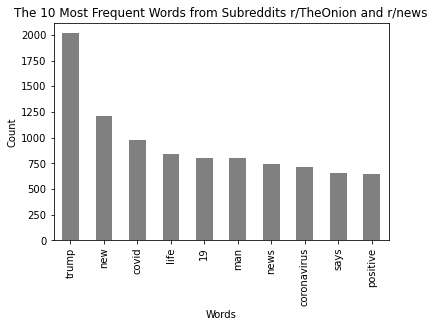

In [107]:
# convert most frequent words to dataframe
most_freq_df = pd.DataFrame(most_freq)

# visualize top 10 words
most_freq_df.nlargest(10, 1).plot(kind = 'bar', legend=None, color='grey')
plt.xticks([i for i in range(10)], [col for col in most_freq_df.nlargest(10, 1)[0]])
plt.xlabel('Words')
plt.ylabel('Count')
plt.title('The 10 Most Frequent Words from Subreddits r/TheOnion and r/news')
plt.savefig('figures/10_most_frequent_words', bbox_inches='tight');

All those words look relevant, so I don't there is any need to add more stop words. However, I may benefit from stemming or keeping some words together like covid and 19. For right now, I will continue with this set.

In [14]:
# how many words total after countervectorizer?
X_train_cvect.shape

(22483, 31904)

### Classification using CounterVectorizer and NaiveBayes

In [64]:
# instatiate naive bayes
nbayes = MultinomialNB()
nbayes.fit(X_train_cvect, y_train)

MultinomialNB()

In [65]:
# score
print('train score:', nbayes.score(X_train_cvect, y_train))
print('test_score:', nbayes.score(X_test_cvect, y_test))

train score: 0.9326157541253391
test_score: 0.8889926617745163


In [105]:
# write scores to file
train_score = nbayes.score(X_train_cvect, y_train)
test_score = nbayes.score(X_test_cvect, y_test)
s_df = pd.DataFrame({'model': 'naive_bayes', 'train_accuracy': train_score, 'test_accuracy': test_score}, index=[0])
score_df = pd.concat([score_df, s_df], ignore_index=True)
score_df.to_csv('data/model_scores.csv', index=False)

In [17]:
# cross validate
cross_val_score(nbayes, X_train_cvect, y_train, cv=3)

array([0.8772515 , 0.87229784, 0.87736856])

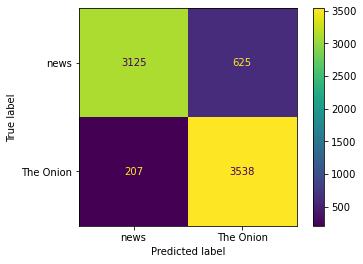

In [18]:
plot_confusion_matrix(nbayes, X_test_cvect, y_test, display_labels=['news', 'The Onion']);

### Classification using TfidfVectorizer and NaiveBayes

In [19]:
# Instantiate the TfidfVectorizer
tvec = TfidfVectorizer(stop_words='english')

In [20]:
X_train_tvec = tvec.fit_transform(X_train, y_train)
X_test_tvec = tvec.transform(X_test)

In [21]:
# fit to naive bayes
nbayes = MultinomialNB()
nbayes.fit(X_train_tvec, y_train)

MultinomialNB()

In [22]:
# score
print('train score:', nbayes.score(X_train_cvect, y_train))
print('test_score:', nbayes.score(X_test_cvect, y_test))

train score: 0.9264333051639017
test_score: 0.8883255503669113


In [23]:
# cross validate
cross_val_score(nbayes, X_train_cvect, y_train, cv=3)

array([0.8772515 , 0.87229784, 0.87736856])

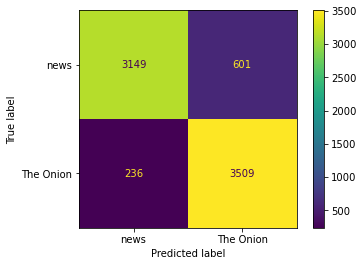

In [24]:
plot_confusion_matrix(nbayes, X_test_cvect, y_test, display_labels=['news', 'The Onion']);

TfidVectorizer or CounterVectorizer don't seem to make a difference on the model, but Bayes is performing best with the defaul settings. I will optimize using TfidVectorizer and Naive Bayes

### Optimazing Naive Bayes with TfidVectorizer

In [25]:
# use pipeline and gridsearch to try to improve the accuracy score
tvec = TfidfVectorizer(stop_words='english')
nbayes = MultinomialNB()

# make a pipeline
pipe = make_pipeline(tvec, nbayes)


params = {
    'tfidfvectorizer__max_features': [2000, 3000, 4000, 500],
    'tfidfvectorizer__min_df': [2 ,3],
    'tfidfvectorizer__max_df': [0.9, 0.95],
    'tfidfvectorizer__ngram_range': [(1,1), (1, 2)],
    'multinomialnb__alpha': [0, 0.001, 0.01, 0.1, 1, 10],
    'multinomialnb__fit_prior': [True, False]
              }

grid = GridSearchCV(pipe, params, n_jobs = -1)

In [26]:
grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(stop_words='english')),
                                       ('multinomialnb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'multinomialnb__alpha': [0, 0.001, 0.01, 0.1, 1, 10],
                         'multinomialnb__fit_prior': [True, False],
                         'tfidfvectorizer__max_df': [0.9, 0.95],
                         'tfidfvectorizer__max_features': [2000, 3000, 4000,
                                                           500],
                         'tfidfvectorizer__min_df': [2, 3],
                         'tfidfvectorizer__ngram_range': [(1, 1), (1, 2)]})

In [27]:
grid.best_params_

{'multinomialnb__alpha': 0.1,
 'multinomialnb__fit_prior': False,
 'tfidfvectorizer__max_df': 0.9,
 'tfidfvectorizer__max_features': 4000,
 'tfidfvectorizer__min_df': 3,
 'tfidfvectorizer__ngram_range': (1, 1)}

In [28]:
# score
print('train score:', grid.score(X_train, y_train))
print('test_score:', grid.score(X_test, y_test))

train score: 0.8886714406440421
test_score: 0.8675116744496331


In [29]:
# try again for more fine tuning

params_2 = {
    'tfidfvectorizer__max_features': [4000, 5000, 10000],
    'tfidfvectorizer__min_df': [1, 2 ,3],
    'tfidfvectorizer__max_df': [0.85, 0.9, 0.92],
    'tfidfvectorizer__ngram_range': [(1,1), (1, 2), (1, 3)],
    'multinomialnb__alpha': [0.1, 1, 10]
              }

grid2 = GridSearchCV(pipe, params_2, n_jobs = -1)

grid2.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(stop_words='english')),
                                       ('multinomialnb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'multinomialnb__alpha': [0.1, 1, 10],
                         'tfidfvectorizer__max_df': [0.85, 0.9, 0.92],
                         'tfidfvectorizer__max_features': [4000, 5000, 10000],
                         'tfidfvectorizer__min_df': [1, 2, 3],
                         'tfidfvectorizer__ngram_range': [(1, 1), (1, 2),
                                                          (1, 3)]})

In [30]:
grid2.best_params_

{'multinomialnb__alpha': 0.1,
 'tfidfvectorizer__max_df': 0.85,
 'tfidfvectorizer__max_features': 10000,
 'tfidfvectorizer__min_df': 2,
 'tfidfvectorizer__ngram_range': (1, 2)}

In [31]:
# score
print('train score:', grid2.score(X_train, y_train))
print('test_score:', grid2.score(X_test, y_test))

train score: 0.9190499488502424
test_score: 0.8821881254169446


### Optimazing Naive Bayes with CounterVectorizer

In [32]:
# use pipeline and gridsearch to try to improve the accuracy score
cvect = CountVectorizer(stop_words='english')
nbayes = MultinomialNB()

# make a pipeline
pipe2 = make_pipeline(cvect, nbayes)


params3 = {
    'countvectorizer__max_features': [5000, 10000],
    'countvectorizer__min_df': [2, 3],
    'countvectorizer__max_df': [0.5, 0.7, 0.9],
    'countvectorizer__ngram_range': [(1,1), (1, 2)],
    'multinomialnb__alpha': [0, 0.001, 0.01, 0.1]
              }

grid3 = GridSearchCV(pipe2, params3, n_jobs = -1)

In [33]:
grid3.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('countvectorizer',
                                        CountVectorizer(stop_words='english')),
                                       ('multinomialnb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'countvectorizer__max_df': [0.5, 0.7, 0.9],
                         'countvectorizer__max_features': [5000, 10000],
                         'countvectorizer__min_df': [2, 3],
                         'countvectorizer__ngram_range': [(1, 1), (1, 2)],
                         'multinomialnb__alpha': [0, 0.001, 0.01, 0.1]})

In [34]:
grid3.best_params_

{'countvectorizer__max_df': 0.5,
 'countvectorizer__max_features': 10000,
 'countvectorizer__min_df': 2,
 'countvectorizer__ngram_range': (1, 1),
 'multinomialnb__alpha': 0.1}

In [35]:
print('train score:', grid3.score(X_train, y_train))
print('test_score:', grid3.score(X_test, y_test))

train score: 0.9200284659520527
test_score: 0.8843228819212808


### Optimazing Naive Bayes with TfidVectorizer and Incorporating WordNetLemmatizer

In [36]:
def split_lemm(text):
    text = text.lower()
    lemm = WordNetLemmatizer()
    return ' '.join([lemm.lemmatize(word) for word in text.split()])

# use pipeline and gridsearch to try to improve the accuracy score
tvec = TfidfVectorizer(stop_words='english')
nbayes = MultinomialNB()

pipe = make_pipeline(tvec, nbayes)


params4 = {
    'tfidfvectorizer__max_features': [5000, 10000, 15000],
    'tfidfvectorizer__min_df': [2 ,3],
    'tfidfvectorizer__max_df': [0.4, 0.6, 0.8],
    'tfidfvectorizer__ngram_range': [(1,1), (1, 2)],
    'tfidfvectorizer__preprocessor': [None, split_lemm],
    'multinomialnb__alpha': [0.01, 0.1, 1]
              }

grid4 = GridSearchCV(pipe, params4, n_jobs = -1)

In [37]:
grid4.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(stop_words='english')),
                                       ('multinomialnb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'multinomialnb__alpha': [0.01, 0.1, 1],
                         'tfidfvectorizer__max_df': [0.4, 0.6, 0.8],
                         'tfidfvectorizer__max_features': [5000, 10000, 15000],
                         'tfidfvectorizer__min_df': [2, 3],
                         'tfidfvectorizer__ngram_range': [(1, 1), (1, 2)],
                         'tfidfvectorizer__preprocessor': [None,
                                                           <function split_lemm at 0x7ff368f07c20>]})

In [38]:
grid4.best_params_

{'multinomialnb__alpha': 0.1,
 'tfidfvectorizer__max_df': 0.4,
 'tfidfvectorizer__max_features': 15000,
 'tfidfvectorizer__min_df': 2,
 'tfidfvectorizer__ngram_range': (1, 2),
 'tfidfvectorizer__preprocessor': None}

In [39]:
print('train score:', grid4.score(X_train, y_train))
print('test_score:', grid4.score(X_test, y_test))

train score: 0.9317261931236934
test_score: 0.8872581721147431


### Optimazing Naive Bayes with TfidVectorizer and Incorporating PorterStemmer

In [40]:
def split_stem(text):
    text = text.lower()
    stem = PorterStemmerr()
    return ' '.join([stem.stem(word) for word in text.split()])

# use pipeline and gridsearch to try to improve the accuracy score
tvec = TfidfVectorizer(stop_words='english')
nbayes = MultinomialNB()

pipe = make_pipeline(tvec, nbayes)


params5 = {
    'tfidfvectorizer__max_features': [10000, 15000],
    'tfidfvectorizer__min_df': [2 ,3],
    'tfidfvectorizer__max_df': [0.4, 0.5],
    'tfidfvectorizer__ngram_range': [(1,1), (1, 2)],
    'tfidfvectorizer__preprocessor': [None, split_stem],
    'multinomialnb__alpha': [0.01, 0.1, 1]
              }

grid5 = GridSearchCV(pipe, params5, n_jobs = -1)

In [41]:
grid5.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(stop_words='english')),
                                       ('multinomialnb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'multinomialnb__alpha': [0.01, 0.1, 1],
                         'tfidfvectorizer__max_df': [0.4, 0.5],
                         'tfidfvectorizer__max_features': [10000, 15000],
                         'tfidfvectorizer__min_df': [2, 3],
                         'tfidfvectorizer__ngram_range': [(1, 1), (1, 2)],
                         'tfidfvectorizer__preprocessor': [None,
                                                           <function split_stem at 0x7ff378811dd0>]})

In [42]:
grid5.best_params_

{'multinomialnb__alpha': 0.1,
 'tfidfvectorizer__max_df': 0.4,
 'tfidfvectorizer__max_features': 15000,
 'tfidfvectorizer__min_df': 2,
 'tfidfvectorizer__ngram_range': (1, 2),
 'tfidfvectorizer__preprocessor': None}

In [44]:
print('train score:', grid5.score(X_train, y_train))
print('test_score:', grid5.score(X_test, y_test))

train score: 0.9317261931236934
test_score: 0.8872581721147431


In [ ]:
# more optimization

In [45]:
def split_stem(text):
    text = text.lower()
    stem = PorterStemmerr()
    return ' '.join([stem.stem(word) for word in text.split()])

# use pipeline and gridsearch to try to improve the accuracy score
tvec = TfidfVectorizer(stop_words='english')
nbayes = MultinomialNB()

pipe = make_pipeline(tvec, nbayes)


params6 = {
    'tfidfvectorizer__max_features': [15000, 20000],
    'tfidfvectorizer__min_df': [1, 2],
    'tfidfvectorizer__max_df': [0.1, 0.4],
    'tfidfvectorizer__ngram_range': [(1,1), (1, 2)],
    'tfidfvectorizer__preprocessor': [None, split_stem],
    'multinomialnb__alpha': [0.05, 0.1, 0.15]
              }

grid6 = GridSearchCV(pipe, params5, n_jobs = -1)

In [46]:
grid6.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(stop_words='english')),
                                       ('multinomialnb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'multinomialnb__alpha': [0.01, 0.1, 1],
                         'tfidfvectorizer__max_df': [0.4, 0.5],
                         'tfidfvectorizer__max_features': [10000, 15000],
                         'tfidfvectorizer__min_df': [2, 3],
                         'tfidfvectorizer__ngram_range': [(1, 1), (1, 2)],
                         'tfidfvectorizer__preprocessor': [None,
                                                           <function split_stem at 0x7ff378811dd0>]})

In [47]:
grid6.best_params_

{'multinomialnb__alpha': 0.1,
 'tfidfvectorizer__max_df': 0.4,
 'tfidfvectorizer__max_features': 15000,
 'tfidfvectorizer__min_df': 2,
 'tfidfvectorizer__ngram_range': (1, 2),
 'tfidfvectorizer__preprocessor': None}

In [48]:
print('train score:', grid6.score(X_train, y_train))
print('test_score:', grid6.score(X_test, y_test))

train score: 0.9317261931236934
test_score: 0.8872581721147431


### Further tuning with CountVectorizer

In [50]:
# use pipeline and gridsearch to try to improve the accuracy score
cvect = CountVectorizer(stop_words='english')
nbayes = MultinomialNB()

# make a pipeline
pipe2 = make_pipeline(cvect, nbayes)


params7 = {
    'countvectorizer__max_features': [20000, 25000],
    'countvectorizer__min_df': [2],
    'countvectorizer__max_df': [0.1, 0.2],
    'countvectorizer__ngram_range': [(1, 2)],
    'multinomialnb__alpha': [0.05, 0.1, 0.5]
              }

grid7 = GridSearchCV(pipe2, params3, n_jobs = -1)

grid7.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('countvectorizer',
                                        CountVectorizer(stop_words='english')),
                                       ('multinomialnb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'countvectorizer__max_df': [0.5, 0.7, 0.9],
                         'countvectorizer__max_features': [5000, 10000],
                         'countvectorizer__min_df': [2, 3],
                         'countvectorizer__ngram_range': [(1, 1), (1, 2)],
                         'multinomialnb__alpha': [0, 0.001, 0.01, 0.1]})

In [51]:
grid7.best_params_

{'countvectorizer__max_df': 0.5,
 'countvectorizer__max_features': 10000,
 'countvectorizer__min_df': 2,
 'countvectorizer__ngram_range': (1, 1),
 'multinomialnb__alpha': 0.1}

In [52]:
print('train score:', grid7.score(X_train, y_train))
print('test_score:', grid7.score(X_test, y_test))

train score: 0.9200284659520527
test_score: 0.8843228819212808


Models from `grid4`, `grid5`, and `grid6` all result in the same scores. I will proceed with `grid4` to analyze further.

### Analysis of the best model

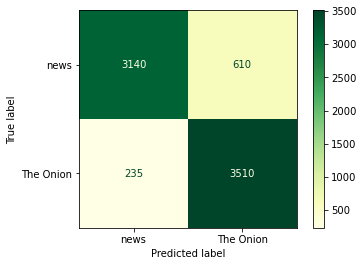

In [53]:
# confusion matrix
fig = plot_confusion_matrix(grid4, X_test, y_test, display_labels=['news', 'The Onion'], cmap='YlGn')
fig;

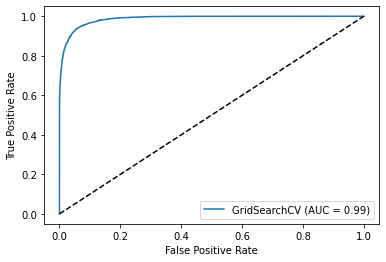

In [84]:
# roc auc curve
plot_roc_curve(grid4, X_train, y_train)
plt.plot([0,1], [0,1], 'k--');

In [55]:
words = grid4.best_estimator_.named_steps['tfidfvectorizer'].get_feature_names()
word_coefs = grid4.best_estimator_.named_steps['multinomialnb'].coef_[0]
word_coef_df = pd.DataFrame({'coefs': word_coefs, 'word': words})

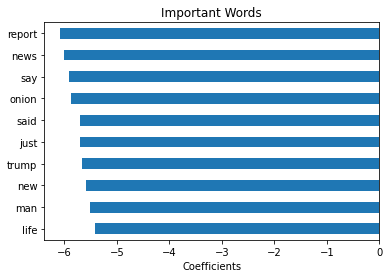

In [86]:
word_coef_df.nlargest(10, 'coefs').plot(kind = 'barh', legend=None)
plt.yticks([i for i in range(10)], word_coef_df.nlargest(10, 'coefs')['word'])
plt.xlabel('Coefficients')
plt.title('Important Words')
plt.savefig('figures/nb_important_words.png', bbox_inches='tight');

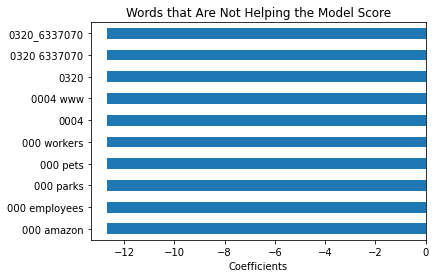

In [93]:
word_coef_df.nsmallest(10, 'coefs').plot(kind = 'barh', legend=None)
plt.yticks([i for i in range(10)], word_coef_df.nsmallest(10, 'coefs')['word'])
plt.xlabel('Coefficients')
plt.title('Words that Are Not Helping the Model Score')
plt.savefig('figures/nb_not_important_words.png', bbox_inches='tight');